In [1]:
import pathlib
import pandas as pd
import numpy as np
import jupedsim as jps
from shapely import Polygon
import shapely
import pedpy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

%matplotlib inline

In [2]:
from typing import Tuple

def generate_points(
    num_points: int,
    length: float = 2.3,
    radius: float = 1.65,
    start: Tuple[float, float] = (0.0, 0.0),
    dx: float = 0.2,
):
    """Generate points on a closed setup with two segments and two half circles."""
    points = [start]
    dphi = np.pi / 40

    center2 = (start[0] + length, start[1] + radius)
    center1 = (start[0], start[1] + radius)

    npoint_on_segment = int(length / dx)
    # first segment
    for i in range(1, npoint_on_segment + 1):
        tmp_point = (start[0] + i * dx, start[1])
        points.append(tmp_point)

    # first half circle
    for phi in np.arange(-np.pi / 2, np.pi / 2, dphi):
        x = center2[0] + radius * np.cos(phi)
        y = center2[1] + radius * np.sin(phi)
        points.append((x, y))

    # second segment
    for i in range(1, npoint_on_segment + 1):
        tmp_point = (
            start[0] + (npoint_on_segment + 1) * dx - i * dx,
            start[1] + 2 * radius,
        )
        points.append(tmp_point)

    # second half circle
    for phi in np.arange(np.pi / 2, 3 * np.pi / 2, dphi):
        x = center1[0] + radius * np.cos(phi)
        y = center1[1] + radius * np.sin(phi)
        points.append((x, y))

    interval = len(points) // num_points
    selected_points = [points[i] for i in range(0, len(points), interval)]
    if len(selected_points) > num_points:
        selected_points = selected_points[:num_points]

    return points, selected_points


all_waypoints, waypoints = generate_points(50)

In [3]:
def find_nearest_clockwise_waypoint(position, all_points, waypoints):
    idx = all_points.index(position)
    while True:
        idx = (idx + 1) % len(all_points)
        if all_points[idx] in waypoints:
            return all_points[idx]

In [4]:
_, exterior = generate_points(50, radius=1.65+0.4, start=(0, -0.4))
_, interior = generate_points(50, radius=1.65-0.4, start=(0,0.4))
walkable_area = pedpy.WalkableArea( shapely.difference(Polygon(exterior), Polygon(interior)))
total_agents = 25 #TODO
all_waypoints, positions = generate_points(total_agents)
choosen_waypoints = []
for position in positions:
    choosen_waypoints.append(
        find_nearest_clockwise_waypoint(position, all_waypoints, all_waypoints)
    )

In [5]:
def plot_points_and_polygons(all_waypoints, choosen_waypoints, exterior, interior, positions):
    __file__, ax = plt.subplots(ncols=1, nrows=1)
    ax.set_aspect("equal")
    x, y = Polygon(all_waypoints).exterior.xy
    plt.plot(x, y, "-r")
    plt.fill(x, y, alpha=0.3)
    plt.scatter(*zip(*all_waypoints), marker=".", label="all points")

    x, y = Polygon(exterior).exterior.xy
    plt.plot(x, y, "-k", label="exterior")
    plt.fill(x, y, alpha=0.3)

    x, y = Polygon(interior).exterior.xy
    plt.plot(x, y, "--k", label="interior")
    plt.fill(x, y, alpha=0.3)

    x, y = Polygon(positions).exterior.xy

    plt.plot(x, y, "xk", ms=10, label="positions")

    
    x, y = Polygon(choosen_waypoints).exterior.xy

    plt.plot(x, y, "ob", ms=5, label="waypoints")
    plt.legend()
    plt.show()

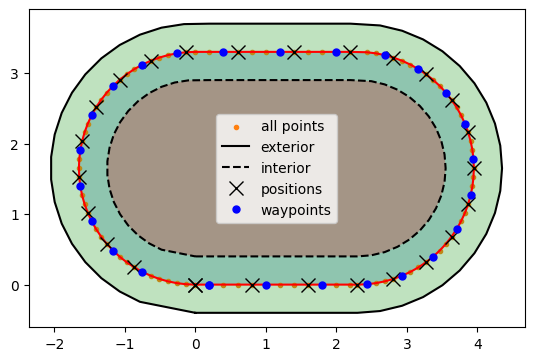

In [6]:
plot_points_and_polygons(all_waypoints, choosen_waypoints,exterior, interior, positions)

In [7]:
trajectory_file =f"single-file-{total_agents}.sqlite"
simulation = jps.Simulation(
        dt=0.05,
        model=jps.VelocityModelParameters(a_ped=2.6, d_ped=0.1, d_wall=0.05),
        #geometry=exterior, excluded_areas = interior,
        geometry=walkable_area.polygon,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file),
        ),
    )

In [8]:
agent_parameters = jps.VelocityModelAgentParameters()
agent_parameters.time_gap = 1
agent_parameters.v0 = 1.2
agent_parameters.radius = 0.2

In [9]:
def compute_unit_vector(new_pos, wp):
    dx = wp[0] - new_pos[0]
    dy = wp[1] - new_pos[1]
    
    magnitude = (dx**2 + dy**2)**0.5
    
    if magnitude == 0:
        return (0,0)
    
    ux = dx / magnitude
    uy = dy / magnitude
    
    return (ux, uy)

In [10]:
waypoint_ids=[]
waypoints = {}
distance = 0.1
for waypoint in all_waypoints:
    wp_id = simulation.add_waypoint_stage(waypoint,distance)
    waypoint_ids.append(wp_id)
    waypoints[waypoint] = wp_id

journey = jps.JourneyDescription(waypoint_ids)
for idx, waypoint in enumerate(waypoint_ids):
    next_waypoint = waypoint_ids[0] if idx == len(waypoint_ids) - 1 else waypoint_ids[idx + 1]
    journey.set_transition_for_stage(waypoint, jps.Transition.create_fixed_transition(next_waypoint))

journey_id = simulation.add_journey(journey)
agent_parameters.journey_id = journey_id

In [11]:
for wp, new_pos in zip(choosen_waypoints, positions):
    agent_parameters.position = new_pos
    agent_parameters.stage_id = waypoints[wp]
    agent_parameters.orientation = compute_unit_vector(new_pos, wp)
    simulation.add_agent(agent_parameters)

In [12]:
number_iterations = 500
while simulation.iteration_count() < number_iterations:
        simulation.iterate()

In [13]:
import plotly.graph_objects as go
import plotly.express as px
import sqlite3

DUMMY_SPEED = -1000

def read_sqlite_file(trajectory_file: str) -> pedpy.TrajectoryData:
    with sqlite3.connect(trajectory_file) as con:
        data = pd.read_sql_query(
            "select frame, id, pos_x as x, pos_y as y, ori_x as ox, ori_y as oy from trajectory_data",
            con,
        )
        fps = float(
            con.cursor()
            .execute("select value from metadata where key = 'fps'")
            .fetchone()[0]
        )
        walkable_area = (
            con.cursor().execute("select wkt from geometry").fetchone()[0]
        )
        return (
            pedpy.TrajectoryData(data=data, frame_rate=fps),
            pedpy.WalkableArea(walkable_area),
        )

def speed_to_color(speed, min_speed, max_speed):
    """Map a speed value to a color using a colormap."""
    normalized_speed = (speed - min_speed) / (max_speed - min_speed)
    r, g, b = plt.cm.jet_r(normalized_speed)[:3]
    return f"rgba({r*255:.0f}, {g*255:.0f}, {b*255:.0f}, 0.5)"


def get_line_color(disk_color):
    r, g, b, _ = [int(float(val)) for val in disk_color[5:-2].split(",")]
    brightness = (r * 299 + g * 587 + b * 114) / 1000
    return "black" if brightness > 127 else "white"


def create_orientation_line(row, line_length=0.2, color="black"):
    end_x = row["x"] + line_length * row["ox"]
    end_y = row["y"] + line_length * row["oy"]

    orientation_line = go.layout.Shape(
        type="line",
        x0=row["x"],
        y0=row["y"],
        x1=end_x,
        y1=end_y,
        line=dict(color=color, width=3),
    )
    return orientation_line


def get_geometry_traces(area):
    geometry_traces = []
    x, y = area.exterior.xy
    geometry_traces.append(
        go.Scatter(
            x=np.array(x),
            y=np.array(y),
            mode="lines",
            line={"color": "grey"},
            showlegend=False,
            name="Exterior",
            hoverinfo="name",
        )
    )
    for inner in area.interiors:
        xi, yi = zip(*inner.coords[:])
        geometry_traces.append(
            go.Scatter(
                x=np.array(xi),
                y=np.array(yi),
                mode="lines",
                line={"color": "grey"},
                showlegend=False,
                name="Obstacle",
                hoverinfo="name",
            )
        )
    return geometry_traces


def get_colormap(frame_data, max_speed):
    """Utilize scatter plots with varying colors for each agent instead of individual shapes.

    This trace is only to incorporate a colorbar in the plot.
    """
    scatter_trace = go.Scatter(
        x=frame_data["x"],
        y=frame_data["y"],
        mode="markers",
        marker=dict(
            size=frame_data["radius"] * 2,
            color=frame_data["speed"],
            colorscale="Jet_r",
            colorbar=dict(title="Speed [m/s]"),
            cmin=0,
            cmax=max_speed,
        ),
        text=frame_data["speed"],
        showlegend=False,
        hoverinfo="none",
    )

    return [scatter_trace]


def get_shapes_for_frame(frame_data, min_speed, max_speed):
    def create_shape(row):
        hover_trace = go.Scatter(
            x=[row["x"]],
            y=[row["y"]],
            text=[f"ID: {row['id']}, Pos({row['x']:.2f},{row['y']:.2f})"],
            mode="markers",
            marker=dict(size=1, opacity=1),
            hoverinfo="text",
            showlegend=False,
        )
        if row["speed"] == DUMMY_SPEED:
            dummy_trace = go.Scatter(
                x=[row["x"]],
                y=[row["y"]],
                mode="markers",
                marker=dict(size=1, opacity=0),
                hoverinfo="none",
                showlegend=False,
            )
            return (
                go.layout.Shape(
                    type="circle",
                    xref="x",
                    yref="y",
                    x0=row["x"] - row["radius"],
                    y0=row["y"] - row["radius"],
                    x1=row["x"] + row["radius"],
                    y1=row["y"] + row["radius"],
                    line=dict(width=0),
                    fillcolor="rgba(255,255,255,0)",  # Transparent fill
                ),
                dummy_trace,
                create_orientation_line(row, color="rgba(255,255,255,0)"),
            )
        color = speed_to_color(row["speed"], min_speed, max_speed)
        return (
            go.layout.Shape(
                type="circle",
                xref="x",
                yref="y",
                x0=row["x"] - row["radius"],
                y0=row["y"] - row["radius"],
                x1=row["x"] + row["radius"],
                y1=row["y"] + row["radius"],
                line_color=color,
                fillcolor=color,
            ),
            hover_trace,
            create_orientation_line(row, color=get_line_color(color)),
        )

    results = frame_data.apply(create_shape, axis=1).tolist()
    shapes = [res[0] for res in results]
    hover_traces = [res[1] for res in results]
    arrows = [res[2] for res in results]
    return shapes, hover_traces, arrows


def create_fig(
    initial_agent_count,
    initial_shapes,
    initial_arrows,
    initial_hover_trace,
    initial_scatter_trace,
    geometry_traces,
    frames,
    steps,
    area_bounds,
    width=800,
    height=800,
    title_note: str = "",
):
    """Creates a Plotly figure with animation capabilities.

    Returns:
        go.Figure: A Plotly figure with animation capabilities.
    """

    minx, miny, maxx, maxy = area_bounds
    title = f"<b>{title_note + '  |  ' if title_note else ''}Number of Agents: {initial_agent_count}</b>"
    fig = go.Figure(
        data=geometry_traces + initial_scatter_trace
        # + hover_traces
        + initial_hover_trace,
        frames=frames,
        layout=go.Layout(
            shapes=initial_shapes + initial_arrows, title=title, title_x=0.5
        ),
    )
    fig.update_layout(
        updatemenus=[_get_animation_controls()],
        sliders=[_get_slider_controls(steps)],
        autosize=False,
        width=width,
        height=height,
        xaxis=dict(range=[minx - 0.5, maxx + 0.5]),
        yaxis=dict(
            scaleanchor="x", scaleratio=1, range=[miny - 0.5, maxy + 0.5]
        ),
    )

    return fig


def _get_animation_controls():
    """Returns the animation control buttons for the figure."""
    return {
        "buttons": [
            {
                "args": [
                    None,
                    {
                        "frame": {"duration": 100, "redraw": True},
                        "fromcurrent": True,
                    },
                ],
                "label": "Play",
                "method": "animate",
            },
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top",
    }


def _get_slider_controls(steps):
    """Returns the slider controls for the figure."""
    return {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right",
        },
        "transition": {"duration": 100, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": steps,
    }


def _get_processed_frame_data(data_df, frame_num, max_agents):
    """Process frame data and ensure it matches the maximum agent count."""
    frame_data = data_df[data_df["frame"] == frame_num]
    agent_count = len(frame_data)
    dummy_agent_data = {"x": 0, "y": 0, "radius": 0, "speed": DUMMY_SPEED}
    while len(frame_data) < max_agents:
        dummy_df = pd.DataFrame([dummy_agent_data])
        frame_data = pd.concat([frame_data, dummy_df], ignore_index=True)
    return frame_data, agent_count


def animate(
    data: pedpy.TrajectoryData,
    area: pedpy.WalkableArea,
    *,
    every_nth_frame: int = 50,
    width: int = 800,
    height: int = 800,
    radius: float = 0.2,
    title_note: str = "",
):
    data_df = pedpy.compute_individual_speed(traj_data=data, frame_step=5)
    data_df = data_df.merge(data.data, on=["id", "frame"], how="left")
    data_df["radius"] = radius
    min_speed = data_df["speed"].min()
    max_speed = data_df["speed"].max()
    max_agents = data_df.groupby("frame").size().max()
    frames = []
    steps = []
    unique_frames = data_df["frame"].unique()
    selected_frames = unique_frames[::every_nth_frame]
    geometry_traces = get_geometry_traces(area.polygon)
    initial_frame_data = data_df[data_df["frame"] == data_df["frame"].min()]
    initial_agent_count = len(initial_frame_data)
    initial_shapes, initial_hover_trace, initial_arrows = get_shapes_for_frame(
        initial_frame_data, min_speed, max_speed
    )
    color_map_trace = get_colormap(initial_frame_data, max_speed)
    for frame_num in selected_frames[1:]:
        frame_data, agent_count = _get_processed_frame_data(
            data_df, frame_num, max_agents
        )
        shapes, hover_traces, arrows = get_shapes_for_frame(
            frame_data, min_speed, max_speed
        )
        title = f"<b>{title_note + '  |  ' if title_note else ''}Number of Agents: {agent_count}</b>"
        frame = go.Frame(
            data=geometry_traces + hover_traces,
            name=str(frame_num),
            layout=go.Layout(
                shapes=shapes + arrows,
                title=title,
                title_x=0.5,
            ),
        )
        frames.append(frame)

        step = {
            "args": [
                [str(frame_num)],
                {
                    "frame": {"duration": 100, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 500},
                },
            ],
            "label": str(frame_num),
            "method": "animate",
        }
        steps.append(step)

    return create_fig(
        initial_agent_count,
        initial_shapes,
        initial_arrows,
        initial_hover_trace,
        color_map_trace,
        geometry_traces,
        frames,
        steps,
        area.bounds,
        width=width,
        height=height,
        title_note=title_note,
    )

In [14]:
trajectories, walkable_area_sqlite = read_sqlite_file(trajectory_file)
animate(trajectories, walkable_area, every_nth_frame=1)

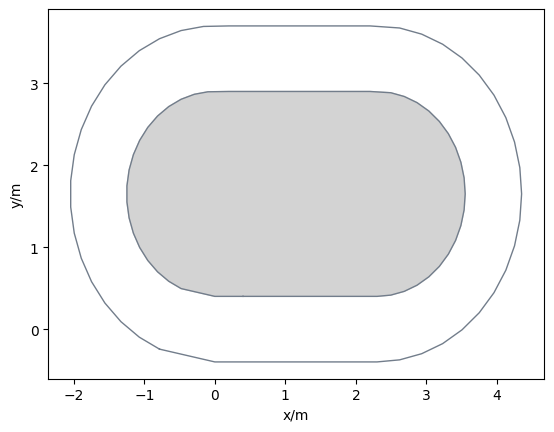

In [15]:
pedpy.plot_walkable_area(walkable_area=walkable_area);

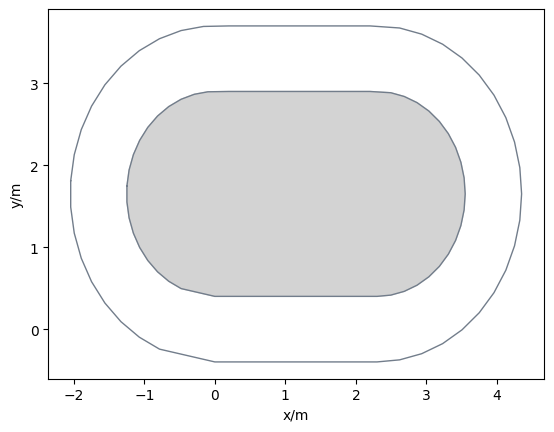

In [16]:
pedpy.plot_walkable_area(walkable_area=walkable_area_sqlite);